<a href="https://colab.research.google.com/github/shaharec/intro-to-Tensorflow-for-Deep-Learning/blob/master/l06c01_tensorflow_hub_and_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Flowers with Transfer Learning
##Steps in soulotion:
1. Import data-
we will import the data from the tensorflow datasets.
2. preprossesing-
we will resize and rescale the images to feat the existing model. 
preform image augmantation on the data.
3. Creat Model-
import Mobilenet model.
creat model then add last later with the number of classes for the flowers.
train only the last layer.
4. Train the model
set number of:
* batch
* epochs
* optimizer 
and so on.
5. Valuate the model
polot loss and accuracy graphs.

#Set up
import neccecary libraries for the classifier

In [1]:
import os
#tensorflow libraies
import tensorflow as tf
import tensorflow_hub as hub 
import tensorflow_datasets as tfds

from tensorflow.keras import Sequential,layers
import numpy as np



In [2]:
import logging 
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

#1.Import data
Lets import the flowers dataset from tensorflow datasets

In [3]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


##Explore dataset

In [4]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.0,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)



In [5]:
num_classes = dataset_info.features['label'].num_classes


In [6]:
num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1
  
for example in validation_set:
  num_validation_examples += 1

In [7]:
print("number of classes: ",num_classes )
print("num of validation data:", num_validation_examples)
print("num of training data:", num_training_examples)


number of classes:  5
num of validation data: 1101
num of training data: 2569


#2. preprocessing the data
The netwerk we will import from TF hub is the MobileNetv2, therefore the resulotion of our images needs to be `224,244` with normelized values.


In [8]:
IMAGE_RES = 224

def format_image(image,label):
  image = tf.image.resize(image,(IMAGE_RES,IMAGE_RES))/255.0
  return image,label

BATCH_SIZE = 32

traine_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = training_set.shuffle(num_validation_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

#Make simple transfer learning usign tensorflow hub
steps:
* creat `feature_extractior` using the model MobileNet v2 **without the final layer.**
* Make the trainable feature false.


In [9]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3),
                                   trainable=False)

#Create the model

In [10]:
model = Sequential()
model.add(feature_extractor)
model.add(layers.Dense(units = num_classes))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


#Train the model

In [11]:
epochs = 6
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(traine_batches,
                    epochs=epochs,
                    validation_data = validation_batches)

Epoch 1/6
81/81 [==============================] - 13s 164ms/step - loss: 0.7882 - accuracy: 0.7014 - val_loss: 0.4330 - val_accuracy: 0.8715
Epoch 2/6
81/81 [==============================] - 12s 153ms/step - loss: 0.3784 - accuracy: 0.8797 - val_loss: 0.3038 - val_accuracy: 0.9093
Epoch 3/6
81/81 [==============================] - 12s 153ms/step - loss: 0.3030 - accuracy: 0.9054 - val_loss: 0.2544 - val_accuracy: 0.9229
Epoch 4/6
81/81 [==============================] - 12s 154ms/step - loss: 0.2522 - accuracy: 0.9245 - val_loss: 0.2133 - val_accuracy: 0.9432
Epoch 5/6
81/81 [==============================] - 13s 155ms/step - loss: 0.2154 - accuracy: 0.9389 - val_loss: 0.1934 - val_accuracy: 0.9478
Epoch 6/6
81/81 [==============================] - 12s 153ms/step - loss: 0.1899 - accuracy: 0.9471 - val_loss: 0.1653 - val_accuracy: 0.9615


#Plot train and validation graphs

In [12]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Training and validation loss')

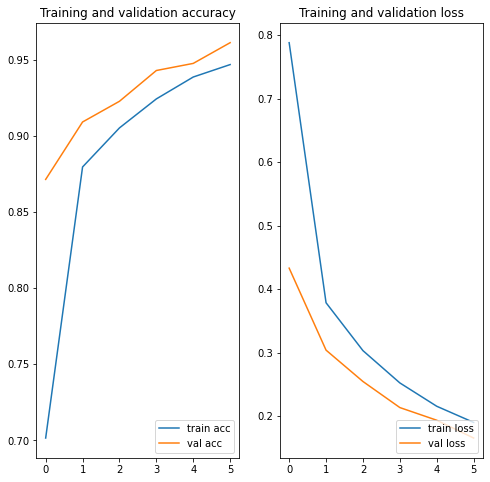

In [13]:
acc = history.history['accuracy']
val_acc =  history.history['val_accuracy']

loss = history.history['loss']
val_loss =  history.history['val_loss']

ep_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(ep_range,acc,label = 'train acc')
plt.plot(ep_range,val_acc,label = 'val acc')
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

plt.subplot(1,2,2)
plt.plot(ep_range,loss,label = 'train loss')
plt.plot(ep_range,val_loss,label = 'val loss')
plt.legend(loc='lower right')
plt.title('Training and validation loss')


#Check predictions

In [15]:
classes_names = np.array(dataset_info.features['label'].names)

print (classes_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


['daisy' 'dandelion' 'roses' 'dandelion' 'tulips' 'tulips' 'daisy'
 'sunflowers' 'dandelion' 'sunflowers' 'tulips' 'tulips' 'tulips'
 'dandelion' 'roses' 'daisy' 'tulips' 'tulips' 'daisy' 'dandelion'
 'dandelion' 'daisy' 'tulips' 'tulips' 'daisy' 'tulips' 'daisy' 'tulips'
 'roses' 'dandelion' 'dandelion' 'dandelion']


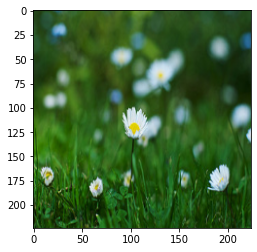

In [20]:
image_batch, label_batch = next(iter(traine_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

#make pridictions

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

pred_id = np.argmax(predicted_batch,axis=-1)
class_name_pred = classes_names[pred_id]
print(class_name_pred)
plt.imshow(image_batch[0])
plt.show()

In [23]:
print("Labels:           ", label_batch)
print("Predicted labels: ", pred_id)

Labels:            [1 0 4 0 2 2 1 3 0 3 2 2 2 0 4 1 2 2 1 0 0 1 2 2 1 2 1 2 4 0 0 0]
Predicted labels:  [1 0 4 0 2 2 1 3 0 3 2 2 2 0 4 1 2 2 1 0 0 1 2 2 1 2 1 2 4 0 0 0]


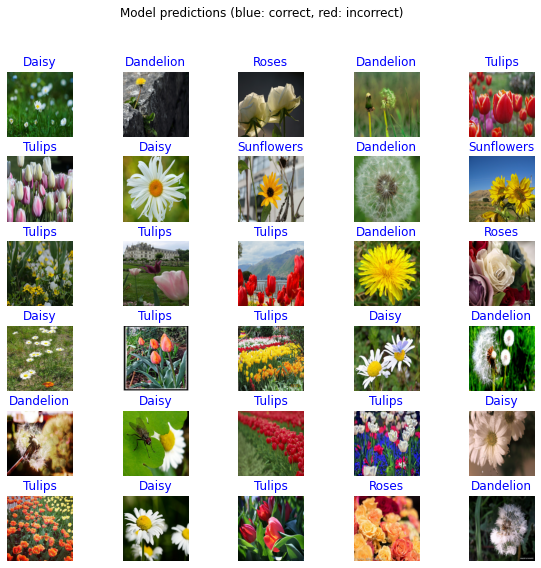

In [30]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if pred_id[n] == label_batch[n] else "red"
  plt.title(class_name_pred[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")